In [1]:
#Do install apoc and graphdatascience packages in neo4j and neo4j, py2neo and matplotlib before running this notebook
#and set apoc.export.file.enabled=true in your apoc.conf
#importing required packages

from neo4j import GraphDatabase
from py2neo import Graph
from py2neo.data import Node, Relationship
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix

In [2]:
#creating driver to connect to Neo4j
url = "bolt://localhost:7687"
username = "neo4j"
password = "anujbansal"

driver = GraphDatabase.driver(url, auth = (username,password))

In [3]:
#function to run cypher queries
def run_cypher_query(query):
    with driver.session() as session:
        result = session.run(query)
        return result.data()

For our usecase we are using the North Carolina 5 million data, provided by "Database Group Leipzig" for Entity Resolution Benchmarking at the following link:
https://dbs.uni-leipzig.de/research/projects/object_matching/benchmark_datasets_for_entity_resolution
Dataset charaterstics:\
A. 5 Sources each having voters' data like - name, surname, subrub and pincode\
B. For our use case we are using the 20,000 records from each source i.e. 100,000 records in total\
C. Each source is duplicate free but shares duplicates from other sources with the synthetically corrupted entity data\
D. Out of 100000 records, 75217(~75%) records are unique entities and 24783 (25%) records are duplicate records\

In [4]:
#EDA in Python
input_csv_path = r"C:\Users\lenovo\.Neo4jDesktop\relate-data\dbmss\dbms-cd0ee55c-8094-4ad6-9f28-ce0e74b0aaf5\import\ncvr_numrec_1000000_modrec_2_ocp_20_myp_0_nump_5.csv"
df = pd.read_csv(input_csv_path, nrows = 20000)
df["source"]= 0
input_csv_path1 = r"C:\Users\lenovo\.Neo4jDesktop\relate-data\dbmss\dbms-cd0ee55c-8094-4ad6-9f28-ce0e74b0aaf5\import\ncvr_numrec_1000000_modrec_2_ocp_20_myp_1_nump_5.csv"
df1 = pd.read_csv(input_csv_path1, nrows = 20000)
df1["source"]= 1
input_csv_path2 = r"C:\Users\lenovo\.Neo4jDesktop\relate-data\dbmss\dbms-cd0ee55c-8094-4ad6-9f28-ce0e74b0aaf5\import\ncvr_numrec_1000000_modrec_2_ocp_20_myp_2_nump_5.csv"
df2 = pd.read_csv(input_csv_path2, nrows = 20000)
df2["source"]= 2
input_csv_path3 = r"C:\Users\lenovo\.Neo4jDesktop\relate-data\dbmss\dbms-cd0ee55c-8094-4ad6-9f28-ce0e74b0aaf5\import\ncvr_numrec_1000000_modrec_2_ocp_20_myp_3_nump_5.csv"
df3 = pd.read_csv(input_csv_path3, nrows = 20000)
df3["source"]= 3
input_csv_path4 = r"C:\Users\lenovo\.Neo4jDesktop\relate-data\dbmss\dbms-cd0ee55c-8094-4ad6-9f28-ce0e74b0aaf5\import\ncvr_numrec_1000000_modrec_2_ocp_20_myp_4_nump_5.csv"
df4 = pd.read_csv(input_csv_path4, nrows = 20000)
df4["source"]= 4

# List of DataFrames
dfs = [df,df1, df2, df3, df4]
# Concatenate the DataFrames
df_combined = pd.concat(dfs, ignore_index=True)
print(df_combined.head())
print(df_combined[df_combined["recid"].isin([878723,101994])].sort_values(by=['recid']))

     recid givenname   surname         suburb postcode  source
0  7852009   kadelyn  gragnani         waxhaw    28|73       0
1  3138435     ronel    carter     washington    2788g       0
2  6117295     jason   roehrig  millers ceeek    286s1       0
3  6401695    antrea      mure     greensboro    27410       0
4  5202204    caedar    oliver   jacksonville    28542       0
        recid givenname      surname        suburb postcode  source
5168   101994     norma  strawl>erry     high poit    27260       0
25214  101994     norma   strawberry    high piont    27210       1
45203  101994      norm   strawberry    high poknt    27260       2
65214  101994     norma   strawbe5ry    high ppint    27260       3
85237  101994     norma   strawbe5ry    hihh point    27260       4
19660  878723   edwarzd       brooks  fayetteviile    28304       0
39656  878723    edward       brookd  fayetteville    283o4       1
59732  878723   edwarcl       brooks   fayettevile    28304       2
79777  878

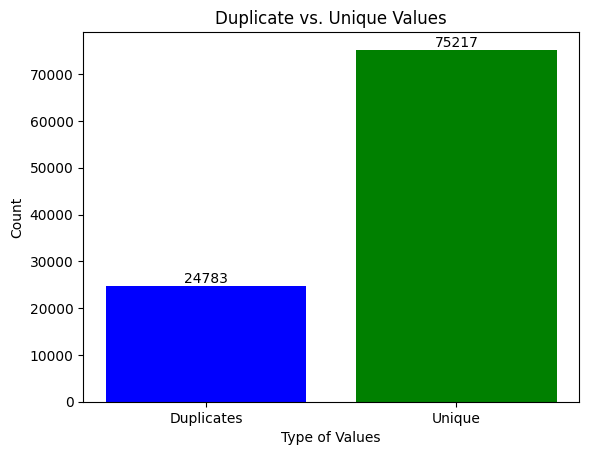

In [8]:
# Calculate the counts of duplicates and unique values
num_duplicates = df_combined["recid"].duplicated().sum()
num_unique = df_combined["recid"].nunique()
# Data for the bars
labels = ['Duplicates', 'Unique']
values = [num_duplicates, num_unique]

# Create a bar chart
plt.bar(labels, values, color=['blue', 'green'])

# Add labels and title
plt.xlabel('Type of Values')
plt.ylabel('Count')
plt.title('Duplicate vs. Unique Values')
# Label the bars with counts
for i, v in enumerate(values):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)
    
# Show the plot
plt.show()


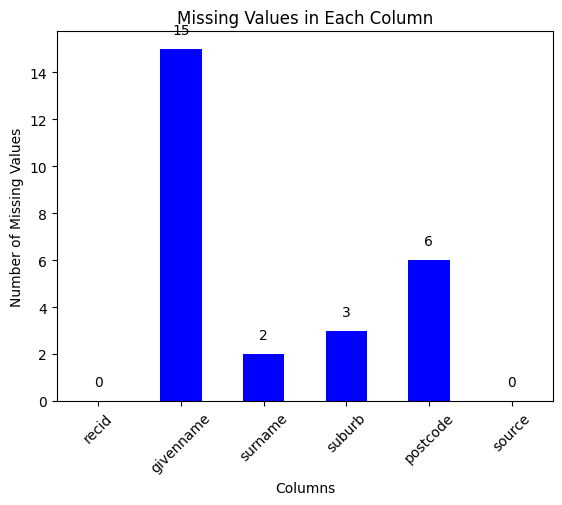

In [14]:
# Calculate the number of missing values for each column
missing_values = df_combined.isnull().sum()

# Create a bar plot
missing_values.plot(kind='bar', color='blue')

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values in Each Column')

# Label the bars with counts
for i, v in enumerate(missing_values):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)


plt.xticks(rotation=45)

# Show the plot
plt.show()

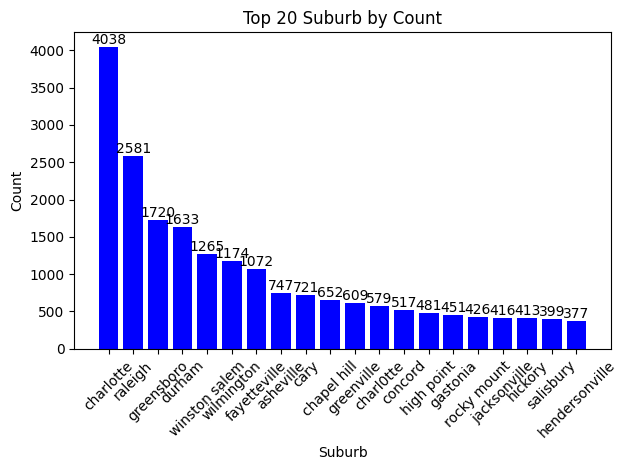

In [15]:
suburb_counts = df_combined['suburb'].value_counts()

# Select the top 10 cities
top_20_suburb = suburb_counts.head(20)

# Create a bar plot
plt.bar(top_20_suburb.index, top_20_suburb, color='blue')

# Add labels and title
plt.xlabel('Suburb')
plt.ylabel('Count')
plt.title('Top 20 Suburb by Count')

# Label the bars with counts
for i, v in enumerate(top_20_suburb):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

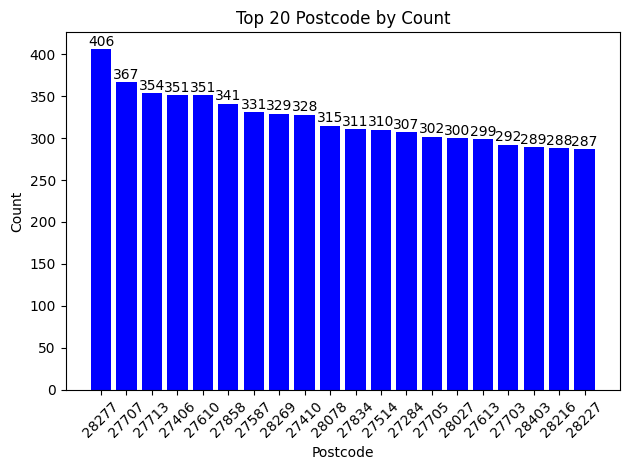

In [16]:
postcode_counts = df_combined['postcode'].value_counts()

# Select the top 10 cities
top_20_postcode = postcode_counts.head(20)

# Create a bar plot
plt.bar(top_20_postcode.index, top_20_postcode, color='blue')

# Add labels and title
plt.xlabel('Postcode')
plt.ylabel('Count')
plt.title('Top 20 Postcode by Count')

# Label the bars with counts
for i, v in enumerate(top_20_postcode):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [17]:
#cleaning the cypher database

query = """
    Match(n) Detach Delete n;
"""
results = run_cypher_query(query)

Each of the source file is getting loaded and cleaned in Neo4j database. Along with loading and cleaning, each record is used to create a node and attributes such as surname, givennamem suburb and postcode are used to create node properites after data cleaning (removal of special characters, changing of case, removal of digits from names etc.). In addition few more properties are derived:
1. Source : SourceKey to identify the source from which record is being loaded
2. surnameKey: Prefix of size 2 of surname
3. givennameKey: prefie of size of 2 of givenname
4. suburbKey: prefie of size of 2 of suburb
5. postcodeKey: prefie of size of 3 of Postcode


In [18]:
#Loading and cleaning the data file 0 in neo4j

query = """LOAD CSV WITH HEADERS FROM "file:///ncvr_numrec_1000000_modrec_2_ocp_20_myp_0_nump_5.csv" AS row
WITH row
LIMIT 20000
CREATE (x:Recid {Recid:row.recid})
SET x.givenname = toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),
x.surname = toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),
x.suburb = toupper(apoc.text.replace(row.suburb,'[^a-zA-Z0-9 ]', '')),
x.postcode = apoc.text.replace(row.postcode,'[^0-9]', ''),
x.source = 0,
x.surnameKey = SUBSTRING(toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),0,2),
x.givennameKey = SUBSTRING(toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),0,2),
x.suburbKey = SUBSTRING(toupper(apoc.text.replace(row.suburb,'[^a-zA-Z ]', '')),0,2),
x.postcodeKey = SUBSTRING(toupper(apoc.text.replace(row.postcode,'[^0-9]', '')),0,3);"""
%time results = run_cypher_query(query)


CPU times: total: 0 ns
Wall time: 4.18 s


In [19]:
#Loading the data file 1 in neo4j
query = """LOAD CSV WITH HEADERS FROM "file:///ncvr_numrec_1000000_modrec_2_ocp_20_myp_1_nump_5.csv" AS row
WITH row
LIMIT 20000
CREATE (x:Recid {Recid:row.recid})
SET x.givenname = toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),
x.surname = toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),
x.suburb = toupper(apoc.text.replace(row.suburb,'[^a-zA-Z0-9 ]', '')),
x.postcode = apoc.text.replace(row.postcode,'[^0-9]', ''),
x.source = 1,
x.surnameKey = SUBSTRING(toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),0,2),
x.givennameKey = SUBSTRING(toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),0,2),
x.suburbKey = SUBSTRING(toupper(apoc.text.replace(row.suburb,'[^a-zA-Z ]', '')),0,2),
x.postcodeKey = SUBSTRING(toupper(apoc.text.replace(row.postcode,'[^0-9]', '')),0,3);"""
%time results = run_cypher_query(query)

CPU times: total: 0 ns
Wall time: 1.8 s


In [20]:
#Loading the data file 2 in neo4j
query = """LOAD CSV WITH HEADERS FROM "file:///ncvr_numrec_1000000_modrec_2_ocp_20_myp_2_nump_5.csv" AS row
WITH row
LIMIT 20000
CREATE (x:Recid {Recid:row.recid})
SET x.givenname = toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),
x.surname = toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),
x.suburb = toupper(apoc.text.replace(row.suburb,'[^a-zA-Z0-9 ]', '')),
x.postcode = apoc.text.replace(row.postcode,'[^0-9]', ''),
x.source = 2,
x.surnameKey = SUBSTRING(toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),0,2),
x.givennameKey = SUBSTRING(toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),0,2),
x.suburbKey = SUBSTRING(toupper(apoc.text.replace(row.suburb,'[^a-zA-Z ]', '')),0,2),
x.postcodeKey = SUBSTRING(toupper(apoc.text.replace(row.postcode,'[^0-9]', '')),0,3);"""
%time results = run_cypher_query(query)

CPU times: total: 0 ns
Wall time: 1.47 s


In [21]:
#Loading the data file 3 in neo4j
query = """LOAD CSV WITH HEADERS FROM "file:///ncvr_numrec_1000000_modrec_2_ocp_20_myp_3_nump_5.csv" AS row
WITH row
LIMIT 20000
CREATE (x:Recid {Recid:row.recid})
SET x.givenname = toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),
x.surname = toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),
x.suburb = toupper(apoc.text.replace(row.suburb,'[^a-zA-Z0-9 ]', '')),
x.postcode = apoc.text.replace(row.postcode,'[^0-9]', ''),
x.source = 3,
x.surnameKey = SUBSTRING(toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),0,2),
x.givennameKey = SUBSTRING(toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),0,2),
x.suburbKey = SUBSTRING(toupper(apoc.text.replace(row.suburb,'[^a-zA-Z ]', '')),0,2),
x.postcodeKey = SUBSTRING(toupper(apoc.text.replace(row.postcode,'[^0-9]', '')),0,3);"""
%time results = run_cypher_query(query)

CPU times: total: 0 ns
Wall time: 1.31 s


In [22]:
#Loading the data file 4 in neo4j
query = """LOAD CSV WITH HEADERS FROM "file:///ncvr_numrec_1000000_modrec_2_ocp_20_myp_4_nump_5.csv" AS row
WITH row
LIMIT 20000
CREATE (x:Recid {Recid:row.recid})
SET x.givenname = toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),
x.surname = toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),
x.suburb = toupper(apoc.text.replace(row.suburb,'[^a-zA-Z0-9 ]', '')),
x.postcode = apoc.text.replace(row.postcode,'[^0-9]', ''),
x.source = 4,
x.surnameKey = SUBSTRING(toupper(apoc.text.replace(row.surname,'[^a-zA-Z ]', '')),0,2),
x.givennameKey = SUBSTRING(toupper(apoc.text.replace(row.givenname,'[^a-zA-Z ]', '')),0,2),
x.suburbKey = SUBSTRING(toupper(apoc.text.replace(row.suburb,'[^a-zA-Z ]', '')),0,2),
x.postcodeKey = SUBSTRING(toupper(apoc.text.replace(row.postcode,'[^0-9]', '')),0,3);"""
%time results = run_cypher_query(query)

CPU times: total: 0 ns
Wall time: 1.39 s


In [23]:
#creation of index in neo4j
query1 = """CREATE INDEX node_range_source FOR (n:Recid) ON (n.source) ;"""
query2 = """CREATE INDEX node_range_surnameKey FOR (n:Recid) ON (n.surnameKey) ;"""
query3 = """CREATE INDEX node_range_givennameKey FOR (n:Recid) ON (n.givennameKey); """
query4 = """CREATE INDEX node_range_suburbKey FOR (n:Recid) ON (n.suburbKey); """
query5 = """CREATE INDEX node_range_postcodeKey FOR (n:Recid) ON (n.postcodeKey); """
%time results = run_cypher_query(query1)
%time results = run_cypher_query(query2)
%time results = run_cypher_query(query3)
%time results = run_cypher_query(query4)
%time results = run_cypher_query(query5)

CPU times: total: 0 ns
Wall time: 78.8 ms
CPU times: total: 0 ns
Wall time: 19.9 ms
CPU times: total: 15.6 ms
Wall time: 34.9 ms
CPU times: total: 0 ns
Wall time: 13.3 ms
CPU times: total: 0 ns
Wall time: 15.6 ms


Here is an example of a sub-graph of few nodes:
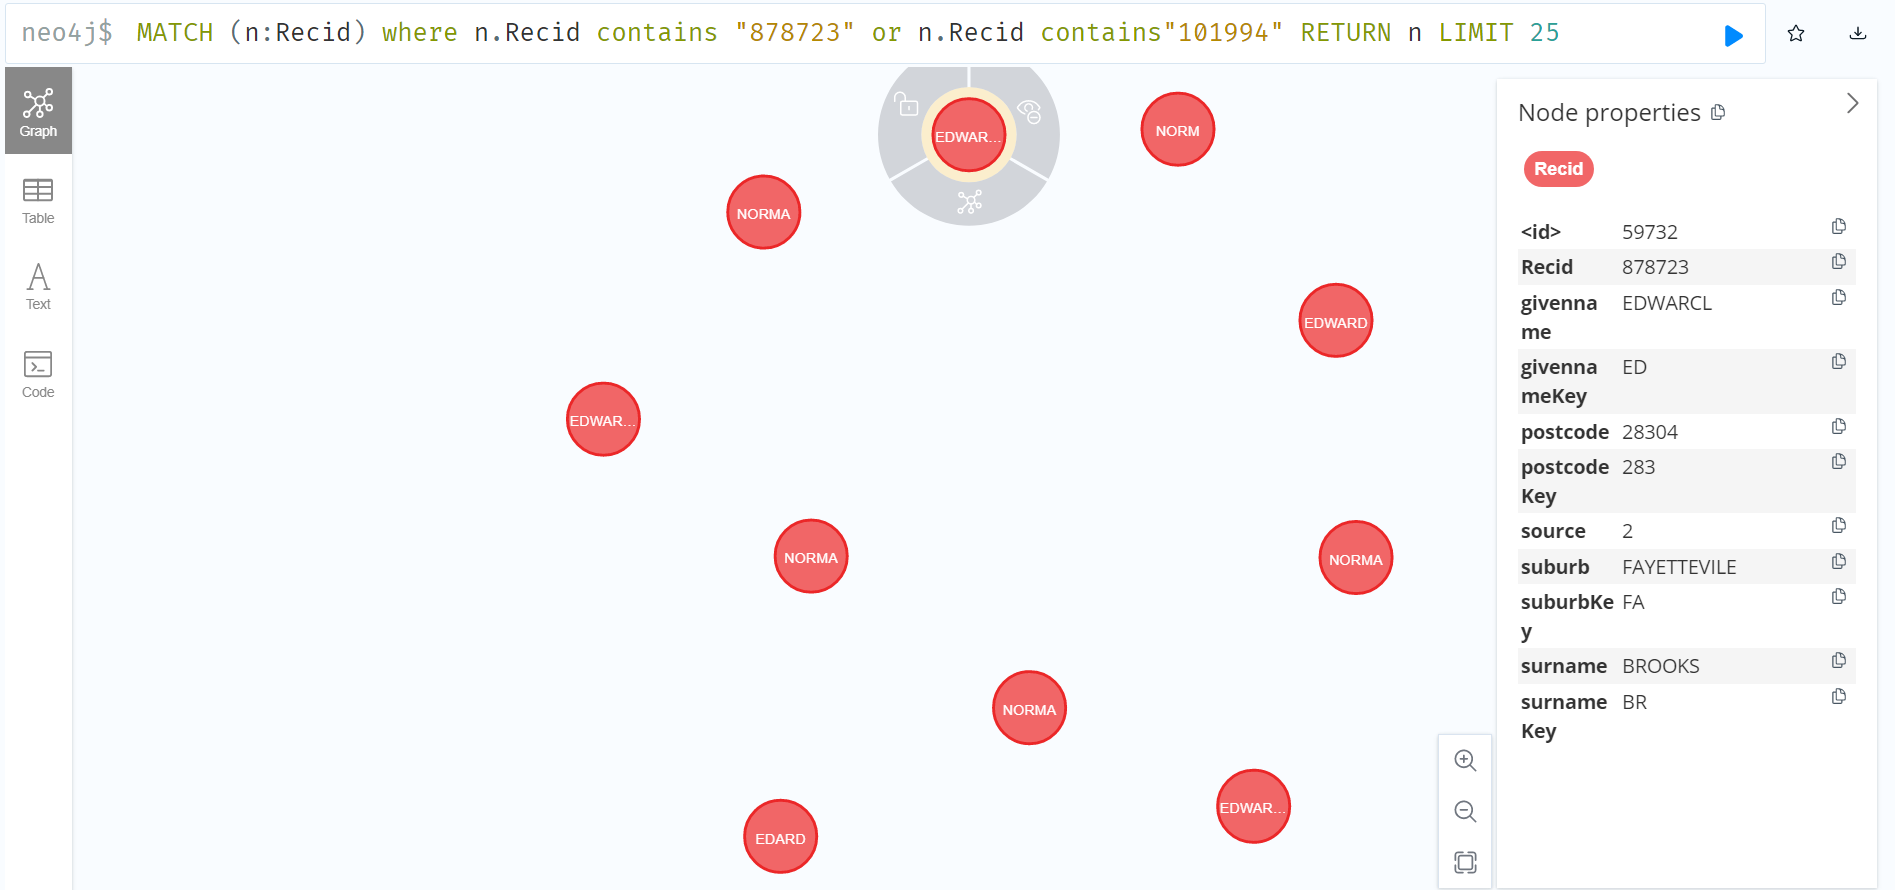

# Workflow

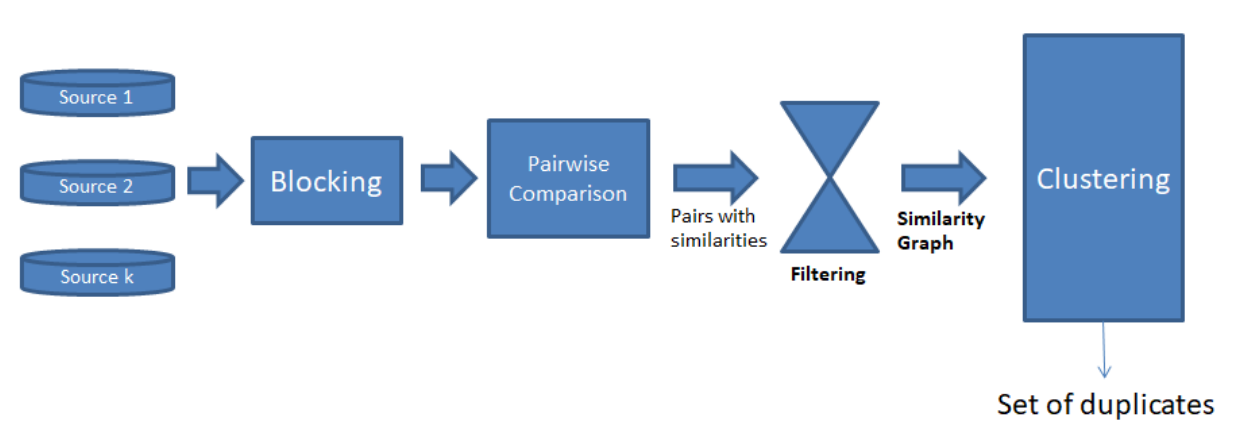

# Data Input
Multiple distinct data sources contain the entities to be matched and grouped. It's worth noting that all sources have been ensured to be free of duplicates.
The blocking process, Pairwise Comparison and Filtering process are executed in four mutually exclusive concurrent phases for improved efficiency:

1. **Phase A:**  Different Source, Same initial prefix of surname, same initial prefix of suburb
2. **Phase B:**  Different Source, Different initial prefix of surname, same initial prefix of givenname, same initial prefix of suburb
3. **Phase C:**  Different Source, Different initial prefix of suburb, Same initial prefix of surname, same initial prefix of postcode
4. **Phase D:**  Different Source, Different initial prefix of suburb, Different initial prefix of surname, same initial prefix of postcode, same initial prefix of givenname



# Blocking Strategy
To optimize the comparison process and minimize redundant computations, a blocking approach is employed. Instead of naively comparing each entity from one data source against all entities from another source, the entities are divided into groups or "blocks" using predefined attributes. This ensures that only entities with identical blocking attributes need to be coed.mpar

# Pairwise Comparison
Within each block originating from any input data source, all entities undergo pairwise comparison. The similarity of attribute for each pair is captured through similarity scores.

# Filtering Process
To determine pairs that are likely matches, a filtering step is introduced. This involves applying predetermined threshold values (established through multiple iterations) to the similarity scores. Pairs with similarity scores exceeding these thresholds are identified.

# Similarity Graph Construction
For the pairs that pass through the filtering stage, a similarity graph is constructed. Edges between vertices are c reated, with the similarity scores serving as the properties of these edges.

# Clustering Phase
This step focuses on the aggregation of related vertices within the similarity graph. Vertices that aareegrouped together usingeir properties..
s syr.e..



Blocking makes the alogrithm more efficient, here is the impact of blocking in present case:

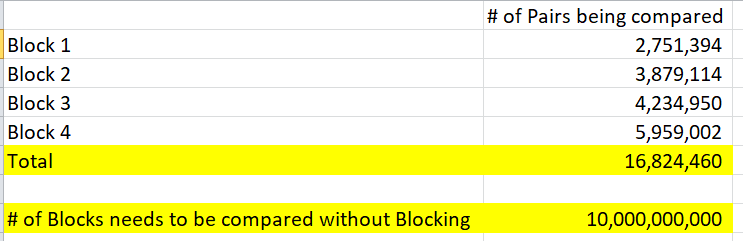.
s syr.e..



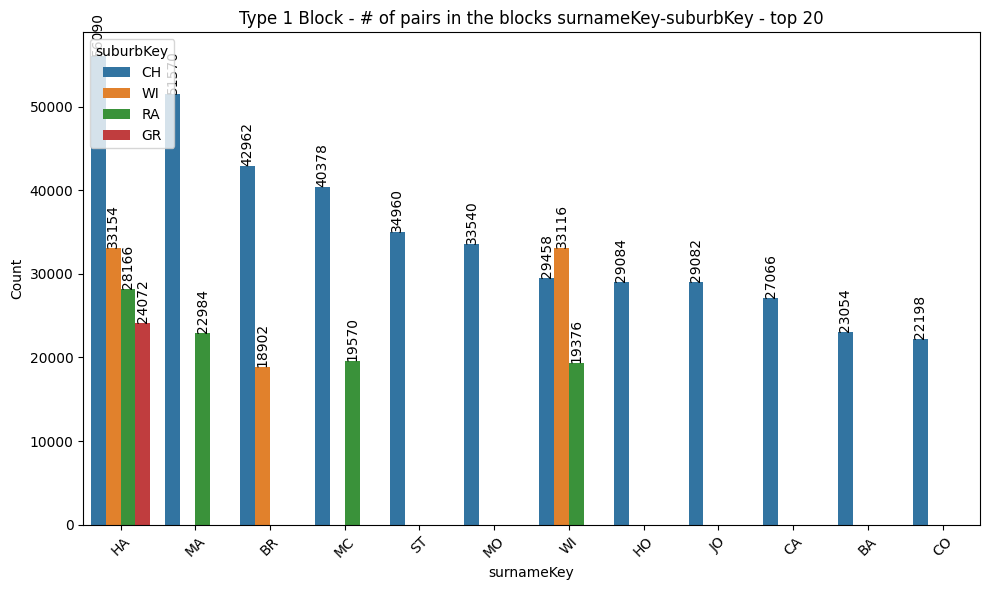

In [68]:
# Query data from Neo4j
result = run_cypher_query("""MATCH(a:Recid)
MATCH(b:Recid)
WHERE a<>b and a.source<>b.source and a.surnameKey = b.surnameKey and a.suburbKey = b.suburbKey
RETURN a.surnameKey AS surnameKey, a.suburbKey AS suburbKey, count(*) As Count ORDER BY Count DESC
LIMIT 20""")

df = pd.DataFrame(result)

# Create a grouped bar plot using seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='surnameKey', y='Count', hue='suburbKey', data=df, errorbar=None)

# Add labels and title
plt.xlabel('surnameKey')
plt.ylabel('Count')
plt.title('Type 1 Block - # of pairs in the blocks surnameKey-suburbKey - top 20')

# Show the legend
plt.legend(title='suburbKey')

for p in ax.patches:
    height = p.get_height()
    if np.isnan(height):
        continue
    plt.annotate(str(int(height)), (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='bottom' if p.get_height() >= 0 else 'top', color='black', fontsize=10, rotation=90)


plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()


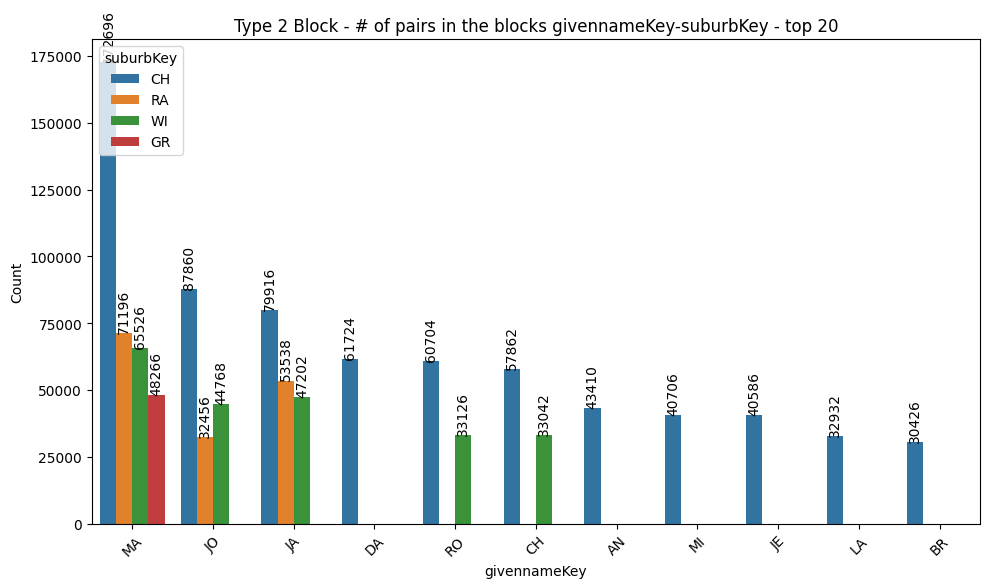

In [69]:
# Query data from Neo4j
result = run_cypher_query("""MATCH(a:Recid)
MATCH(b:Recid)
WHERE a<>b and a.source<>b.source and a.surnameKey <> b.surnameKey and a.givennameKey = b.givennameKey and a.suburbKey = b.suburbKey
RETURN a.givennameKey AS givennameKey, a.suburbKey AS suburbKey, count(*) As Count ORDER BY Count DESC
LIMIT 20""")

df = pd.DataFrame(result)

# Create a grouped bar plot using seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='givennameKey', y='Count', hue='suburbKey', data=df, errorbar=None)

# Add labels and title
plt.xlabel('givennameKey')
plt.ylabel('Count')
plt.title('Type 2 Block - # of pairs in the blocks givennameKey-suburbKey - top 20')

# Show the legend
plt.legend(title='suburbKey')

for p in ax.patches:
    height = p.get_height()
    if np.isnan(height):
        continue
    plt.annotate(str(int(height)), (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='bottom' if p.get_height() >= 0 else 'top', color='black', fontsize=10, rotation=90)



plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


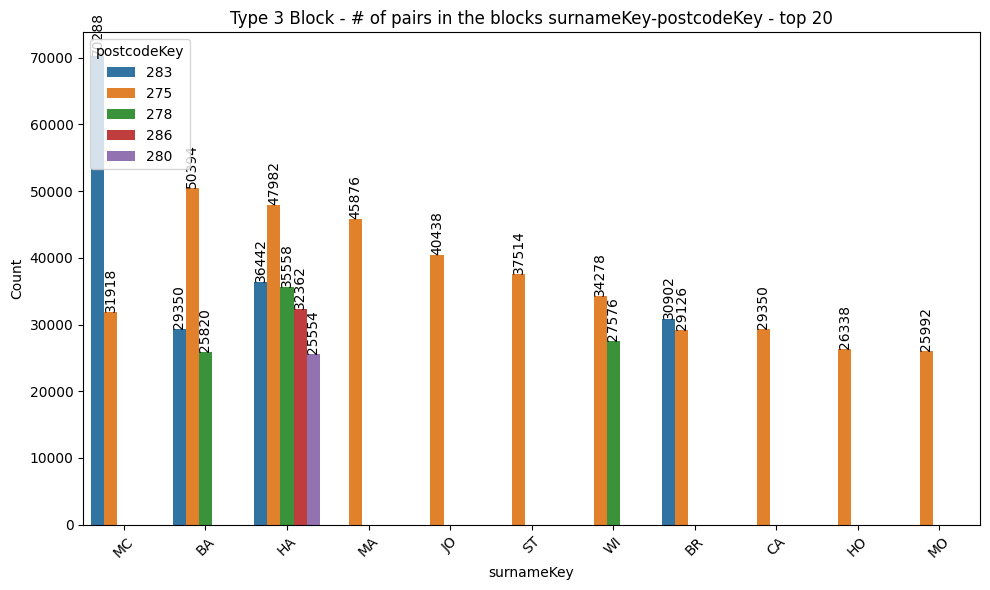

In [70]:
# Query data from Neo4j
result = run_cypher_query("""MATCH(a:Recid)
MATCH(b:Recid)
WHERE a<>b and a.source<>b.source and a.surnameKey = b.surnameKey  and a.suburbKey <> b.suburbKey and 
a.postcodeKey = b.postcodeKey
RETURN a.surnameKey AS surnameKey, a.postcodeKey AS postcodeKey, count(*) As Count ORDER BY Count DESC
LIMIT 20""")

df = pd.DataFrame(result)

# Create a grouped bar plot using seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='surnameKey', y='Count', hue='postcodeKey', data=df, errorbar=None)

# Add labels and title
plt.xlabel('surnameKey')
plt.ylabel('Count')
plt.title('Type 3 Block - # of pairs in the blocks surnameKey-postcodeKey - top 20')

# Show the legend
plt.legend(title='postcodeKey')

for p in ax.patches:
    height = p.get_height()
    if np.isnan(height):
        continue
    plt.annotate(str(int(height)), (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='bottom' if p.get_height() >= 0 else 'top', color='black', fontsize=10, rotation=90)



plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


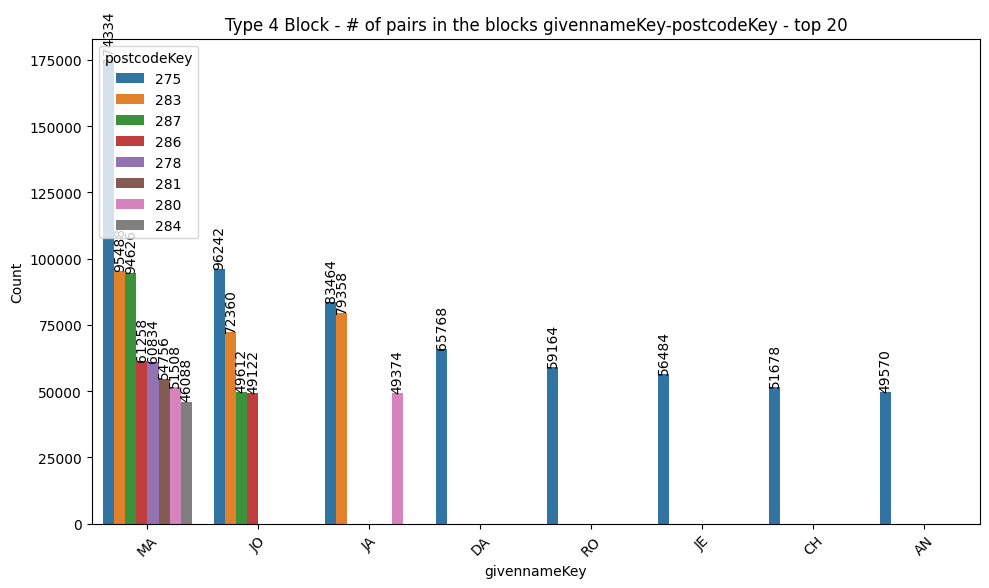

In [71]:
# Query data from Neo4j
result = run_cypher_query("""MATCH(a:Recid)
MATCH(b:Recid)
WHERE a<>b and a.source<>b.source and a.surnameKey <> b.surnameKey and a.givennameKey = b.givennameKey and a.suburbKey <> b.suburbKey and 
a.postcodeKey = b.postcodeKey
RETURN a.givennameKey AS givennameKey, a.postcodeKey AS postcodeKey, count(*) As Count ORDER BY Count DESC
LIMIT 20""")

df = pd.DataFrame(result)

# Create a grouped bar plot using seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='givennameKey', y='Count', hue='postcodeKey', data=df, errorbar=None)

# Add labels and title
plt.xlabel('givennameKey')
plt.ylabel('Count')
plt.title('Type 4 Block - # of pairs in the blocks givennameKey-postcodeKey - top 20')

# Show the legend
plt.legend(title='postcodeKey')

for p in ax.patches:
    height = p.get_height()
    if np.isnan(height):
        continue
    plt.annotate(str(int(height)), (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='bottom' if p.get_height() >= 0 else 'top', color='black', fontsize=10, rotation=90)



plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [72]:
phaseA = """
   //Pre-fix blocking with selecting records from different sources as we assume that each source dont have duplicates
MATCH(a:Recid)
MATCH(b:Recid)
WHERE a<>b and a.source<>b.source and a.surnameKey = b.surnameKey and a.suburbKey = b.suburbKey

//calculating similarities using jaroWinklerDistance
WITH *, 
toInteger(100 - apoc.text.jaroWinklerDistance(a.surname,b.surname)*100) AS sim_surname,
toInteger(100 - apoc.text.jaroWinklerDistance(a.givenname,b.givenname)*100) AS sim_givenname,
toInteger(100- apoc.text.jaroWinklerDistance(a.suburb,b.suburb)*100) AS sim_suburb,
toInteger(100 - apoc.text.jaroWinklerDistance(a.postcode,b.postcode)*100) AS sim_postcode
//filetring based on threshold
WHERE sim_surname> 85 and sim_givenname>85 and sim_suburb>65 and sim_postcode>65
//creating relationships for identified after threshold
MERGE (a)-[r:similar{sim_surname:sim_surname,sim_givenname:sim_givenname,sim_suburb:sim_suburb,sim_postcode:sim_postcode}]-(b)
"""

phaseB =  """
//Pre-fix blocking with selecting records from different sources as we assume that each source dont have duplicates
MATCH(a:Recid)
MATCH(b:Recid)
WHERE a<>b and a.source<>b.source and a.surnameKey <> b.surnameKey and a.givennameKey = b.givennameKey and a.suburbKey = b.suburbKey

//calculating similarities using jaroWinklerDistance
WITH *, 
toInteger(100 - apoc.text.jaroWinklerDistance(a.surname,b.surname)*100) AS sim_surname,
toInteger(100 - apoc.text.jaroWinklerDistance(a.givenname,b.givenname)*100) AS sim_givenname,
toInteger(100- apoc.text.jaroWinklerDistance(a.suburb,b.suburb)*100) AS sim_suburb,
toInteger(100 - apoc.text.jaroWinklerDistance(a.postcode,b.postcode)*100) AS sim_postcode
//filetring based on threshold
WHERE sim_surname> 85 and sim_givenname>85 and sim_suburb>65 and sim_postcode>65
//creating relationships for identified after threshold
MERGE (a)-[r:similar{sim_surname:sim_surname,sim_givenname:sim_givenname,sim_suburb:sim_suburb,sim_postcode:sim_postcode}]-(b)
"""

phaseC =  """
//Pre-fix blocking with selecting records from different sources as we assume that each source dont have duplicates
MATCH(a:Recid)
MATCH(b:Recid)
WHERE a<>b and a.source<>b.source and a.surnameKey = b.surnameKey  and a.suburbKey <> b.suburbKey and 
a.postcodeKey = b.postcodeKey

//calculating similarities using jaroWinklerDistance
WITH *, 
toInteger(100 - apoc.text.jaroWinklerDistance(a.surname,b.surname)*100) AS sim_surname,
toInteger(100 - apoc.text.jaroWinklerDistance(a.givenname,b.givenname)*100) AS sim_givenname,
toInteger(100- apoc.text.jaroWinklerDistance(a.suburb,b.suburb)*100) AS sim_suburb,
toInteger(100 - apoc.text.jaroWinklerDistance(a.postcode,b.postcode)*100) AS sim_postcode
//filetring based on threshold
WHERE sim_surname> 85 and sim_givenname>85 and sim_suburb>65 and sim_postcode>65
//creating relationships for identified after threshold
MERGE (a)-[r:similar{sim_surname:sim_surname,sim_givenname:sim_givenname,sim_suburb:sim_suburb,sim_postcode:sim_postcode}]-(b)
"""

phaseD =  """
//Pre-fix blocking with selecting records from different sources as we assume that each source dont have duplicates
MATCH(a:Recid)
MATCH(b:Recid)
WHERE a<>b and a.source<>b.source and a.surnameKey <> b.surnameKey and a.givennameKey = b.givennameKey and a.suburbKey <> b.suburbKey and 
a.postcodeKey = b.postcodeKey

//calculating similarities using jaroWinklerDistance
WITH *, 
toInteger(100 - apoc.text.jaroWinklerDistance(a.surname,b.surname)*100) AS sim_surname,
toInteger(100 - apoc.text.jaroWinklerDistance(a.givenname,b.givenname)*100) AS sim_givenname,
toInteger(100- apoc.text.jaroWinklerDistance(a.suburb,b.suburb)*100) AS sim_suburb,
toInteger(100 - apoc.text.jaroWinklerDistance(a.postcode,b.postcode)*100) AS sim_postcode
//filetring based on threshold
WHERE sim_surname> 85 and sim_givenname>85 and sim_suburb>65 and sim_postcode>65
//creating relationships for identified after threshold
MERGE (a)-[r:similar{sim_surname:sim_surname,sim_givenname:sim_givenname,sim_suburb:sim_suburb,sim_postcode:sim_postcode}]-(b)
"""



In [73]:

def main():
    with GraphDatabase.driver(url, auth = (username,password)) as driver:
        similarity_scores(driver)

def similarity_scores(driver):
   

    # Session a
    with driver.session(database="neo4j") as session_a:
        session_a.run(phaseA) 

    # Session b
    with driver.session(database="neo4j") as session_b:
        session_b.run(phaseB)

    # Session c
    with driver.session(database="neo4j") as session_c:
        session_c.run(phaseC) 

    # Session d
    with driver.session(database="neo4j") as session_d:
        session_d.run(phaseD)

if __name__ == "__main__":
    %time main()
    



CPU times: total: 0 ns
Wall time: 7min 1s


After blocking, similarity score calculations and filerting, selected pairs of entities are linked together with similarity scores forming the property of edges
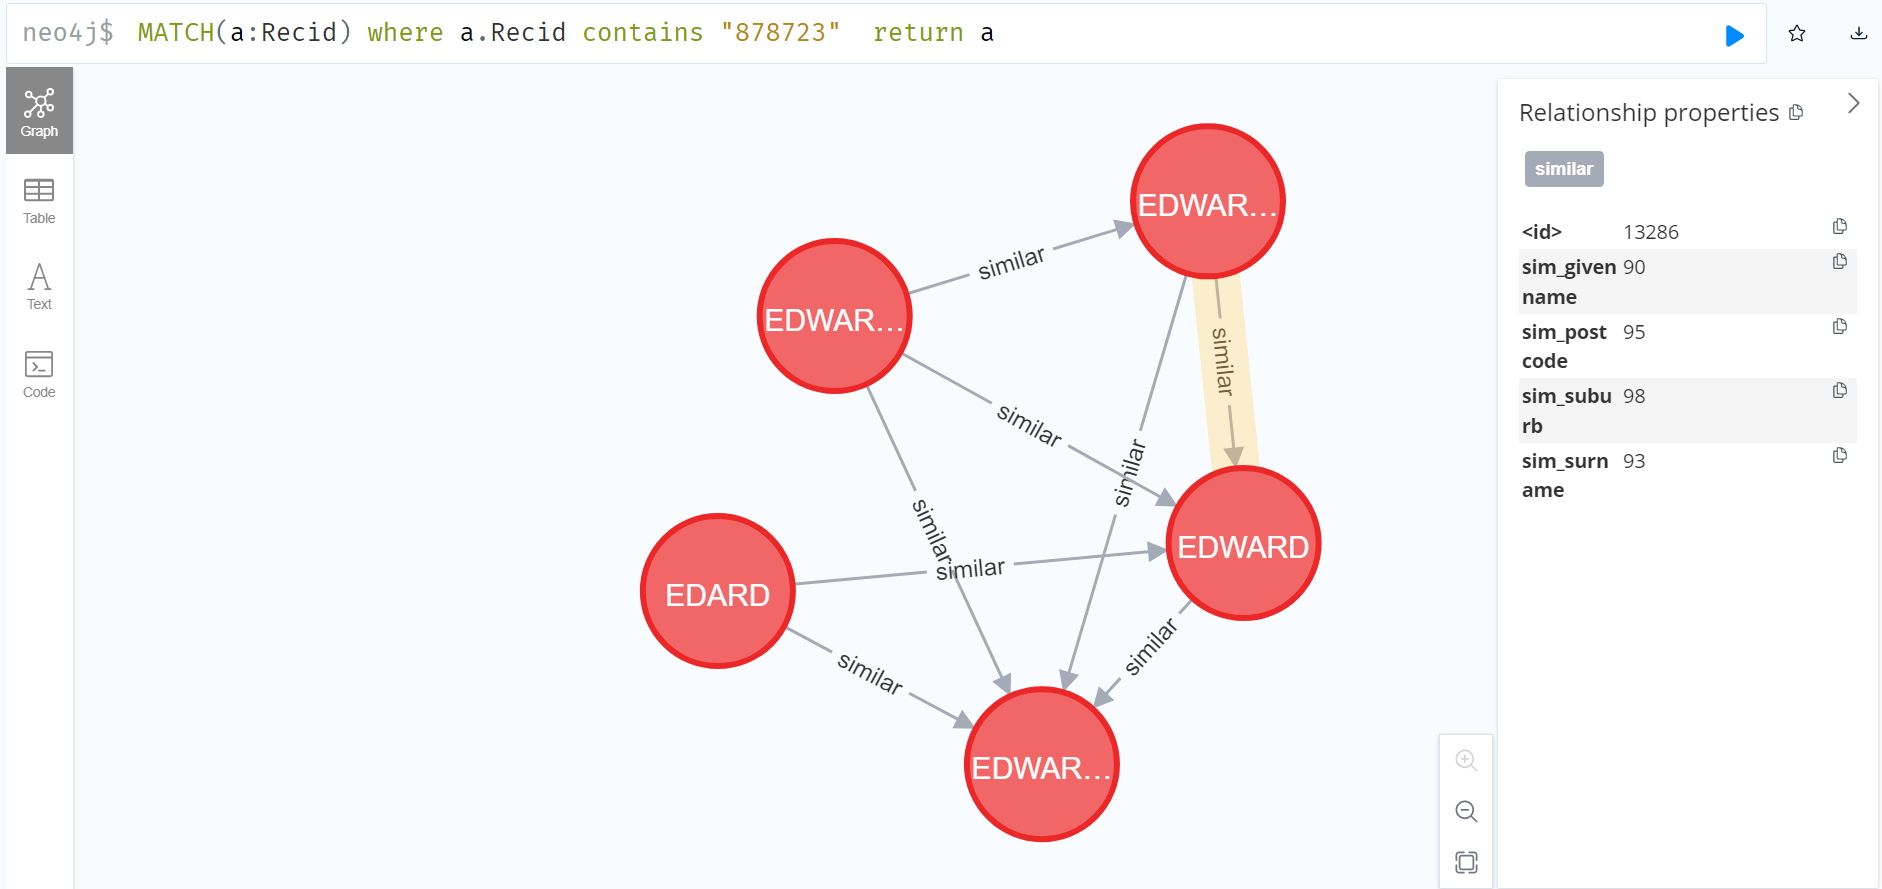

In [80]:
query ="""CALL gds.graph.drop('mygraph2', false) YIELD graphName;"""
%time results = run_cypher_query(query)

CPU times: total: 15.6 ms
Wall time: 4.99 ms


In [81]:
#graph creation in neo4j
query = """
CALL gds.graph.project(
	'mygraph2',
	'Recid',
	{
	similar:{
	orientation:'UNDIRECTED',
	properties:['sim_surname','sim_givenname','sim_suburb','sim_postcode']
	}
	}
)
"""
%time results = run_cypher_query(query)

CPU times: total: 0 ns
Wall time: 241 ms


In [82]:
#entity resolution in neo4j
query = """
CALL gds.labelPropagation.write('mygraph2', { writeProperty: 'community' }) YIELD communityCount, ranIterations, didConverge
"""
%time results = run_cypher_query(query)

CPU times: total: 15.6 ms
Wall time: 625 ms


Here is an example how communities are assigned to entities similar to each other:

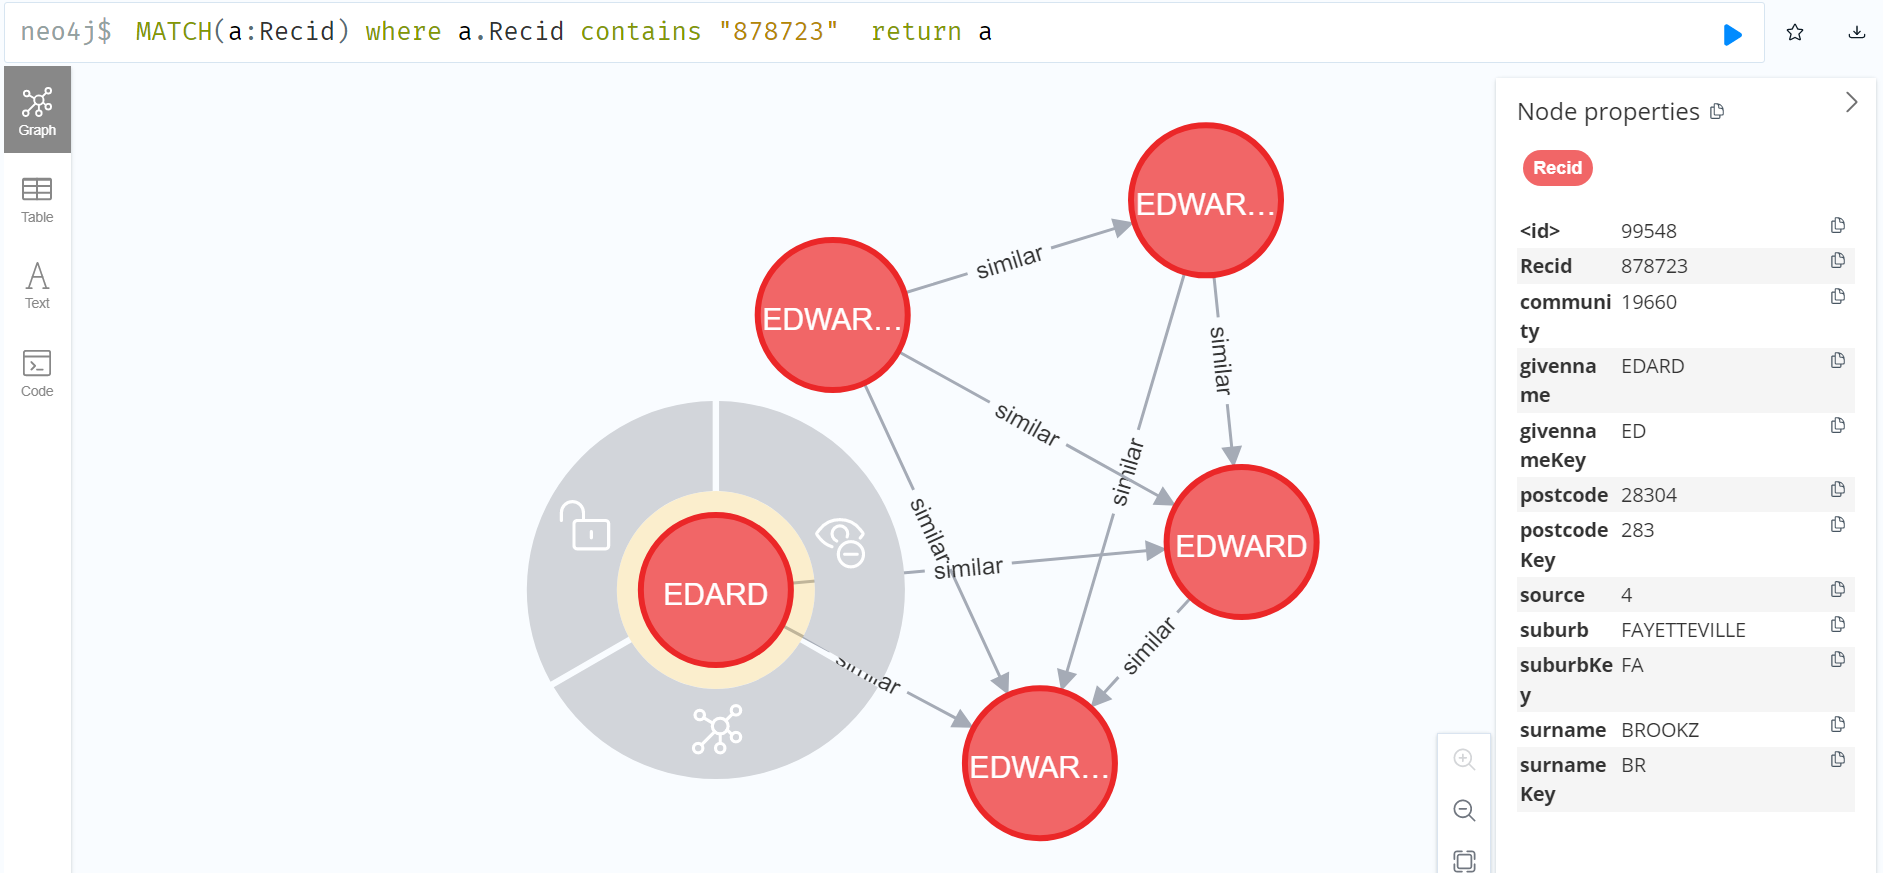

Properties of another node in same cluster:

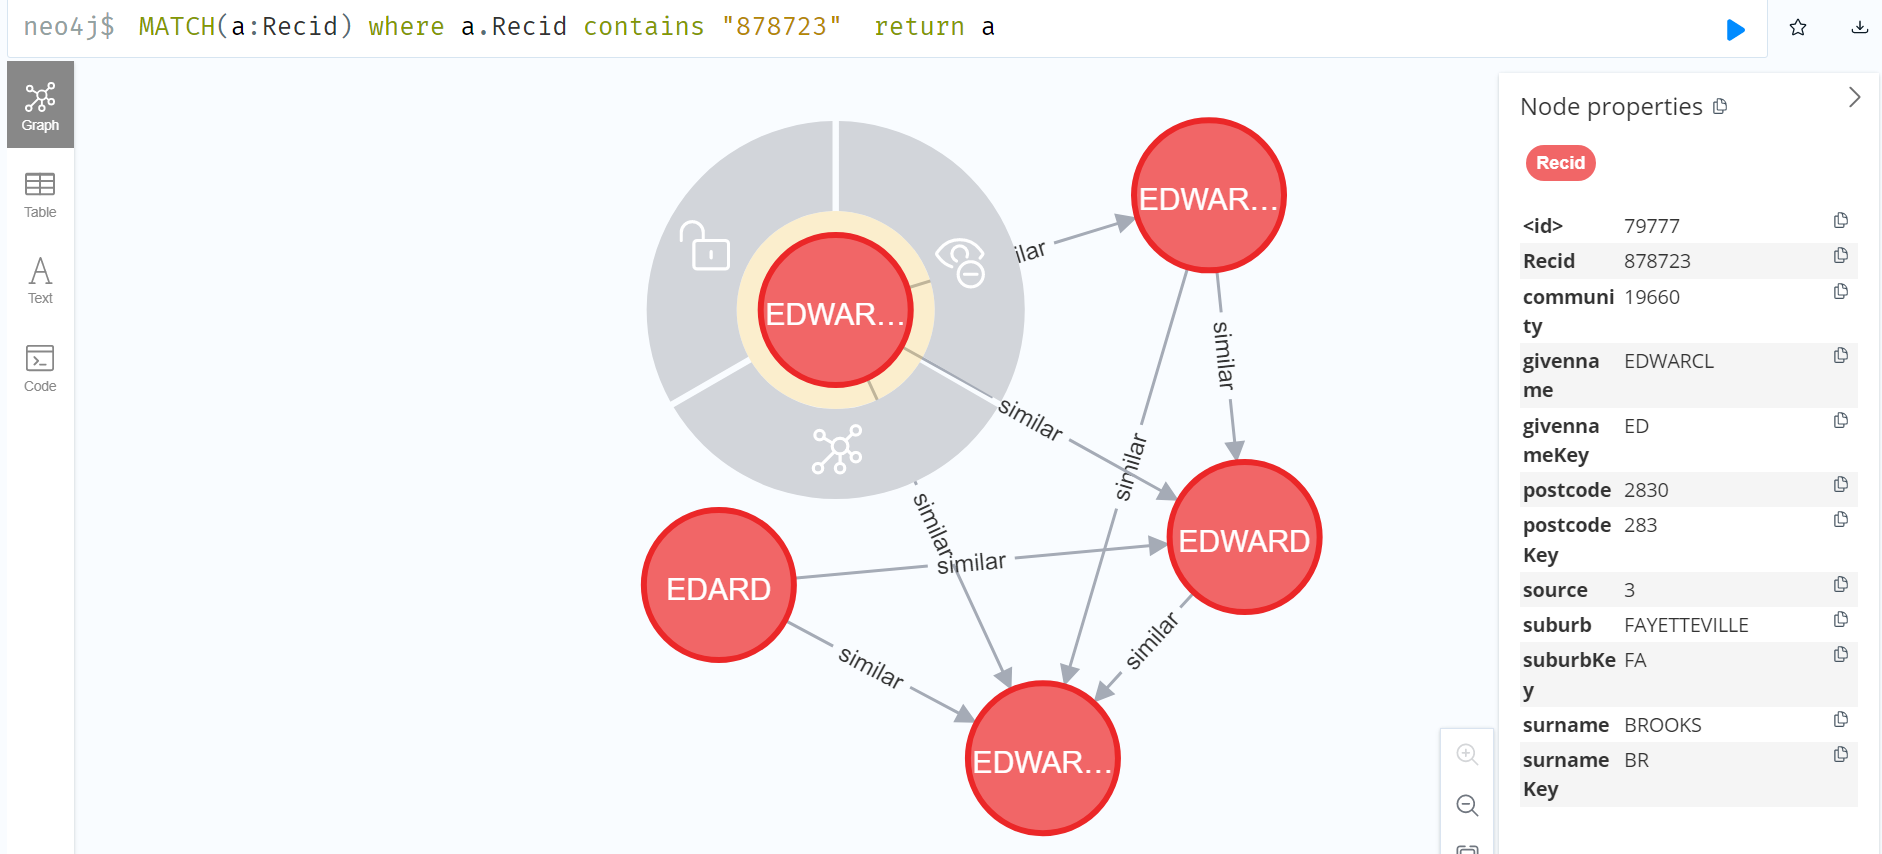


In [43]:
#exporting the output
query ="""
call apoc.export.csv.query("Match(n) Return n.Recid as Recid, n.community as community, n.surname as surname, n.givenname as givenname,n.postcode as postcode,n.suburb as suburb,n.source as source,n.surnameKey as surnameKey,n.givennameKey as givennameKey,n.suburbKey as suburbKey,n.postcodeKey as postcodeKey","export14.csv",{})
"""
results = run_cypher_query(query)

In [83]:
driver.close()

In [7]:
csv_path = r"C:\Users\lenovo\Downloads\export14.csv"
df = pd.read_csv(csv_path)
print(df.head)

<bound method NDFrame.head of             Recid  community     surname  givenname postcode           suburb  \
0      "07852009"          0  "GRAGNANI"  "KADELYN"   "2873"         "WAXHAW"   
1      "03138435"      60001    "CARTER"    "RONEL"   "2788"     "WASHINGTON"   
2      "06117295"      60003   "ROEHRIG"    "JASON"   "2861"  "MILLERS CEEEK"   
3      "06401695"          3      "MURE"   "ANTREA"  "27410"     "GREENSBORO"   
4      "05202204"      40002    "OLIVER"   "CAEDAR"  "28542"   "JACKSONVILLE"   
...           ...        ...         ...        ...      ...              ...   
99995   "6200144"      99995    "LARSON"  "BARBATA"   "2831"   "FAYETTEVILLE"   
99996   "3983781"      99996    "LAUREL"  "JANEQTE"  "27408"     "GREENSBORO"   
99997   "7165975"      99997  "ATKINSON"    "LOGAN"  "28447"       "CALABSSH"   
99998    "969491"      99998      "ALLN"  "CHESTER"  "27705"         "DUHRAM"   
99999   "4026584"      99999    "MURJAY"  "TIFFAAY"  "27615"        "RALEIGH"  

In [8]:
df['Recid'] =pd.to_numeric(df['Recid'].str.replace('"',''))
print(df.head)

<bound method NDFrame.head of          Recid  community     surname  givenname postcode           suburb  \
0      7852009          0  "GRAGNANI"  "KADELYN"   "2873"         "WAXHAW"   
1      3138435      60001    "CARTER"    "RONEL"   "2788"     "WASHINGTON"   
2      6117295      60003   "ROEHRIG"    "JASON"   "2861"  "MILLERS CEEEK"   
3      6401695          3      "MURE"   "ANTREA"  "27410"     "GREENSBORO"   
4      5202204      40002    "OLIVER"   "CAEDAR"  "28542"   "JACKSONVILLE"   
...        ...        ...         ...        ...      ...              ...   
99995  6200144      99995    "LARSON"  "BARBATA"   "2831"   "FAYETTEVILLE"   
99996  3983781      99996    "LAUREL"  "JANEQTE"  "27408"     "GREENSBORO"   
99997  7165975      99997  "ATKINSON"    "LOGAN"  "28447"       "CALABSSH"   
99998   969491      99998      "ALLN"  "CHESTER"  "27705"         "DUHRAM"   
99999  4026584      99999    "MURJAY"  "TIFFAAY"  "27615"        "RALEIGH"   

       source surnameKey givennam

In [12]:
df = df.sort_values(by=['Recid', 'community'])
df['Recid_lag'] = df.groupby('Recid')['Recid'].shift(1)
df['true_positives'] = df.apply(lambda row: 0 if pd.isna(row['Recid_lag']) else 1, axis=1)
df = df.sort_values(by=['community', 'Recid'])
df['community_lag'] = df.groupby('community')['community'].shift(1)
df['identified_positives'] = df.apply(lambda row: 0 if pd.isna(row['community_lag']) else 1, axis=1)
cm = confusion_matrix(df['true_positives'], df['identified_positives'])
print("Confusion Matrix:")
print(cm)



Confusion Matrix:
[[74865   352]
 [ 5539 19244]]


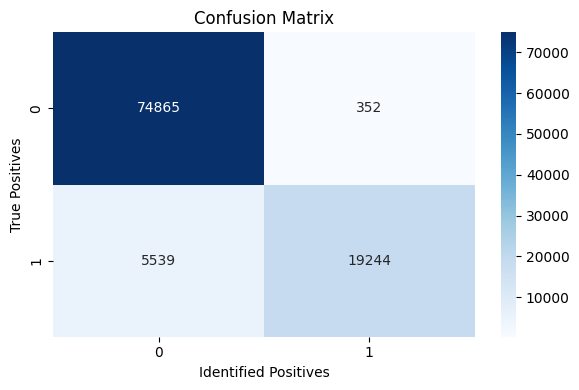

In [14]:

# Create a heatmap for the confusion matrix with cell annotations
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Identified Positives')
plt.ylabel('True Positives')
plt.title('Confusion Matrix')

# Show the plot
plt.tight_layout()
plt.show()


Out of 24783 actual duplicate records, model is correctly able to identify 19244 (~77.7%) duplicate records. And 366 records identified as duplicates by model are false positives with a false positive rate of 1.8%. End to End runtime for 100,000 records is around ~7 minutes.

In the current dataset, all the columns that are at our disposal—namely, surname, givenname, suburb, and postcode—have been compromised. This compromises the potential for effective blocking, consequently constraining the possibility of a successful operation. Moreover, dedicating efforts to improve recall adversely affects precision.

However, with the presence of just one intact column, the blocking process can be notably streamlined, leading to enhanced overall performance, increased recall, and improved precision.